In order to use dataset we have in google drive. This is done so we don't have to mount the zip file again and again.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Unzip the file. Put the location of the file in double quotes.

In [ ]:
import os
os.mkdir('data')
os.mkdir("dataset")
os.mkdir('results')

In [ ]:
!unzip "/content/drive/MyDrive/Gate/temp/Major Project/Model/dataset/places.zip" -d "/content/dataset"

Installing split-folders in order to split the folders into training, validation and testing data. Here, the split is in the ration of 80%, 10%, 10%. All three of the folders are put in the folder of output/pistachio.

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import shutil
source = 'dataset'
destination = 'data'
shutil.move(source, destination)

'data/dataset'

In [ ]:
import splitfolders
splitfolders.ratio('data/dataset', output="output", seed=1337, ratio=(.90, .10), group_prefix=None)

Defining the paths to the folders of train, val and test folders.

In [ ]:
train_path = 'output/train'
val_path = 'output/val'

Importing the necessary libraries.

In [ ]:
from IPython.display import Image, display
from skimage.color import lab2rgb, rgb2lab, gray2rgb
from tensorflow.keras.preprocessing import image
from skimage.io import imshow, imshow_collection
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
# import keras
import os

from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from skimage.transform import resize
from skimage.io import imsave

Viewing an image inside the folder to check how it looks pre-processing.

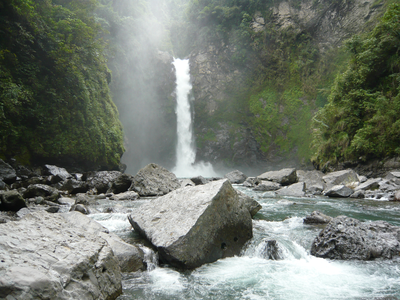

In [ ]:
imgsrc = train_path + '/dataset/100201.png'
Image(imgsrc, width=100, height=100)

Importing the pre-trained VGG-16 model trained on imagenet. We set it as trainable = False, which means the weights in the hidden layers won't be readjusted again and again. This is done to reduce the training time.

Here, we are only adding the convolutional layers, as we only want the VGG-16 to perform as an encoder. These are the layers that perform the feature extraction.

In [ ]:
vgg16model = tf.keras.applications.vgg16.VGG16(input_shape=(256,256,3), include_top=False)
vgg16model.trainable = False
vgg16model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
newmodel = Sequential()
for layer in vgg16model.layers[:]:
    newmodel.add(layer)
newmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 64, 64, 256)       2

In [ ]:
#FOR COMBINATION RESULTS
from tensorflow.keras.layers import Dropout, BatchNormalization
newmodel = Sequential([
    vgg16model.layers[0],
    vgg16model.layers[1],
    vgg16model.layers[2],
    vgg16model.layers[3],
    BatchNormalization(),
    vgg16model.layers[4],
    vgg16model.layers[5],
    vgg16model.layers[6],
    BatchNormalization(),
    vgg16model.layers[7],
    vgg16model.layers[8],
    vgg16model.layers[9],
    vgg16model.layers[10],
    BatchNormalization(),
    vgg16model.layers[11],
    vgg16model.layers[12],
    vgg16model.layers[13],
    vgg16model.layers[14],
    BatchNormalization(),
    vgg16model.layers[15],
    vgg16model.layers[16],
    vgg16model.layers[17],
    vgg16model.layers[18],
    Conv2D(512, (3,3), activation='relu', padding='same'),
    Dropout(0.9)
])
newmodel4.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                      

Creating batches of the training data. Here, rescale is being done to normalize the values between 0 and 1. To do this, we are dividing the image values by 255 because the images currently are in RGB format and RGB values range from 0 to 255. The reason we need to do the normalization at all is because the activation function we use (ReLu) uses values between 0 and 1.

In [ ]:
#FOR IMAGE AUGMENTATION
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=[0.8,1.2],
                                    zoom_range=[0.8, 1.2]
                                    )
train_batches = train_datagen.flow_from_directory(train_path,
                                                 target_size=(256,256),
                                                 batch_size=64,
                                                 class_mode=None)

val_datagen = ImageDataGenerator(rescale=1. / 255)
val_batches = train_datagen.flow_from_directory(val_path,
                                                 target_size=(256,256),
                                                 batch_size=64,
                                                 class_mode=None)

Found 796 images belonging to 1 classes.
Found 9 images belonging to 1 classes.


Here, we can see how the image is being converted to black and white. We are using rgb2lab to convert the image into lab colors. We know that L is for lightness, and shows image in grayscale and a & b are the colors. We can put these different aspects of the images inside the variables. To understand the meaning of [:,:,0], we need to know that an image is depicted as (224,224,3) which means the height is 224, width is 224, and we are inclusing all 3 channels. So, [:,:,0] means we want all the height, all the width, and only the first channel, which is L.

<Figure size 640x480 with 0 Axes>

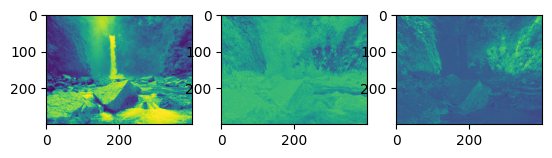

In [ ]:
tempimg = load_img(imgsrc)
labtemp = rgb2lab(tempimg)
L = labtemp[:,:,0]
A = labtemp[:,:,1]
B = labtemp[:,:,2]
plt.figure()
f, axarr = plt.subplots(1, 3) #subplot(r,c) provide the no. of rows and columns.
# use the created array to output your multiple images. In this case I have stacked 3 images horizontally
axarr[0].imshow(L)
axarr[1].imshow(A)
axarr[2].imshow(B)

We have 2 empty lists X and Y. In order to include all images, and not just images from one batch (of 32 images), we can use 2 for loops. Divide the total number of images by 32 to get how many times the code needs to repeat. Then, in the next loop, we can see that in that batch, for every img, we connvert it into lab colors, and put L in X and a&b together in Y. For Y, it is divided by 128 because A and B values range from -127 to 128, so we divide the values by 128 to restrict values to between -1 and 1.

X becomes input and Y becomes output we need. We also reshape X so that X and Y are of the same dimensions.

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

0
Before re-shaping:  (768, 256, 256)
(768, 256, 256, 1)
(768, 256, 256, 2)


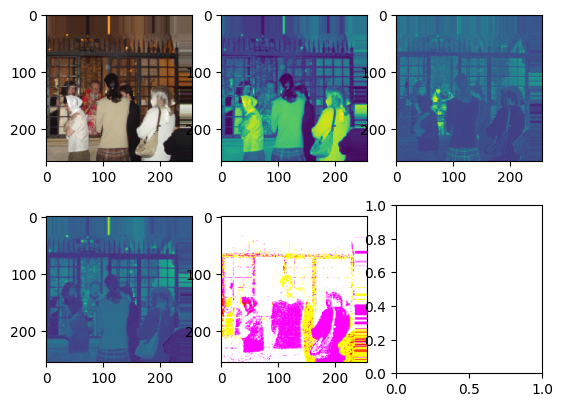

In [ ]:
X =[]
Y =[]
j = True
for i in range(N//64):
  for img in train_batches[i]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0])
        Y.append(lab[:,:,1:] / 128)
        if i == 0 and j == True:
          j = False
          imshow_collection([img, lab[:,:,0], lab[:,:,1], lab[:,:,2], lab])
          print(i)
    except:
      print('error')
X = np.array(X)
Y = np.array(Y)
print("Before re-shaping: ", X.shape)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)

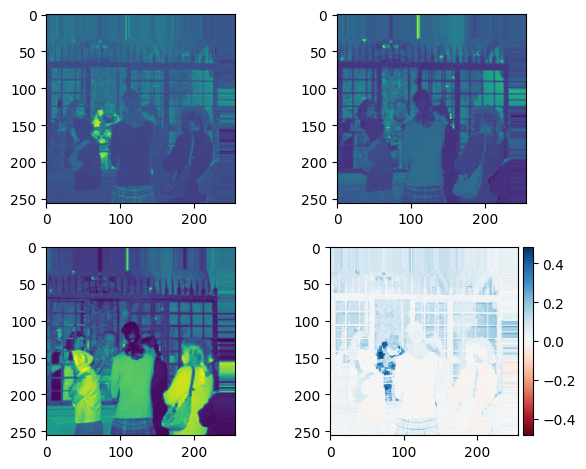

In [ ]:
imshow_collection([Y[0][:,:,0], Y[0][:,:,1], X[0][:,:,0]])
imshow(Y[0][:,:,0])

Now we have one channel of L in each layer but, VGG16 is expecting 3 dimension, so we repeated the L channel two times to get 3 dimensions of the same L channel.

We basically take the image from X, convert it into rgb. It does not become colored, it just copies the lightness channel 3 times, so the dimensions of input images become (224,224,3) from (224,224,1)

Then, we use the newmodel to predict the output. And we use reshape to ensure the shape is of the correct size. We put these predictions in an array vggfeatures, which is what we send to the decoder to upscale.



In [ ]:
#FOR VGG16
vggfeatures = []
for i, sample in enumerate(X):
  sample = gray2rgb(sample)
  sample = sample.reshape((1,256,256,3))
  prediction = newmodel.predict(sample)
  prediction = prediction.reshape((8,8,512))
  vggfeatures.append(prediction)
vggfeatures = np.array(vggfeatures)
print(vggfeatures.shape)

1/1 [==============================] - 0s 21ms/step
(768, 8, 8, 512)


This is the decoder. We know the input shape is of (7,7,512). We want to reduce the last, and increase the first two, so the final shape becomes (224,224,2), which is the prediction.

The first convolutional layer is to reduce the last part. We half it to 256. Then, again to 128. Then we use an upsampling layer to increase the (7,7) to (14,14), doubling it. This goes on till the last layer gives the desired result.

In [ ]:
#VGG 16
model = Sequential()
model.add(Conv2D(256, (3,3), activation='relu', padding='same', input_shape=(8,8,512)))
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 256)         1179904   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         295040    
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        73792     
                                                                 
 up_sampling2d_1 (UpSampling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)       

In [ ]:
#FOR VGG16
print(vggfeatures.shape)
print(Y.shape)

(768, 8, 8, 512)
(768, 256, 256, 2)


Compiling the model. We use Adam Optimizer, Mean Square error, and we have 10 epochs withc batch sizes as 128. The input is vggfeatures, and tested against Y.

In [ ]:
#FOR VGG16 AND BATCH NORMALIZATION
from tqdm.keras import TqdmCallback
model.compile(optimizer='Adam', loss='mse' , metrics=['accuracy'])
model.fit(vggfeatures, Y, epochs=30, batch_size=32, verbose = 0, callbacks=[TqdmCallback(verbose=2)])

In [ ]:
#FOR VGG16
model.save('colorize_autoencoder_vgg16.model')

Here, we are going to run the model on the images in the test folder. The output coloured images are then saved.

(256, 256, 3)
1/1 [==============================] - 0s 329ms/step


(256, 256, 3)
1/1 [==============================] - 0s 21ms/step


(256, 256, 3)
1/1 [==============================] - 0s 21ms/step


(256, 256, 3)
1/1 [==============================] - 0s 20ms/step


(256, 256, 3)
1/1 [==============================] - 0s 21ms/step


(256, 256, 3)
1/1 [==============================] - 0s 18ms/step


(256, 256, 3)
1/1 [==============================] - 0s 20ms/step


(256, 256, 3)
1/1 [==============================] - 0s 19ms/step


(256, 256, 3)
1/1 [==============================] - 0s 21ms/step


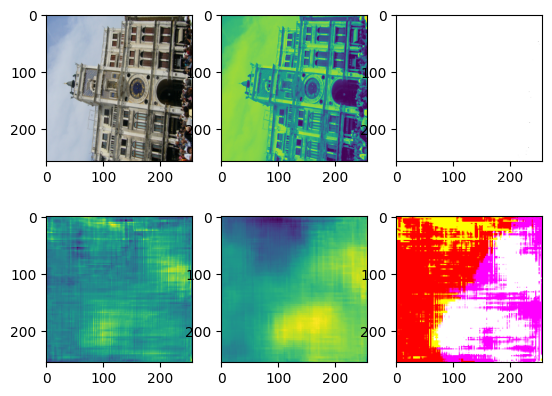

In [ ]:
#FOR VGG16
model = tf.keras.models.load_model('colorize_autoencoder_vgg16.model',
                                   custom_objects=None,
                                   compile=True)
files = os.listdir(val_path + '/dataset/')
for idx, file in enumerate(files):
  if idx<250:
    testimg = val_path+'/dataset/'+file
    test = img_to_array(load_img(val_path+'/dataset/'+file))
    test = resize(test, (256,256), anti_aliasing=True)
    test*= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    print(L.shape)
    L = L.reshape((1,256,256,3))
    #print(L.shape)
    vggpred = newmodel.predict(L)
    ab = model.predict(vggpred)
    #print(ab.shape)
    ab = ab*128
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    if idx == 0:
      imshow_collection([test, l, L[0], cur[:,:,1], cur[:,:,2], cur])
    imsave('results/result'+str(idx)+".jpg", lab2rgb(cur))

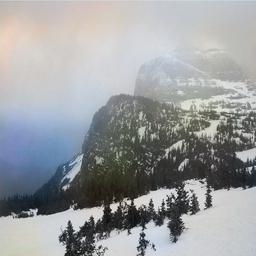

In [ ]:
imgres = "/content/results4/result1.jpg"
Image(imgres)

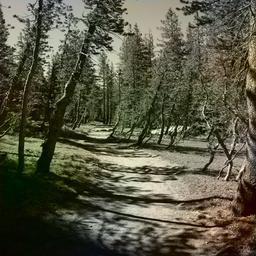

In [ ]:
imgres = "/content/results4/result50.jpg"
Image(imgres)

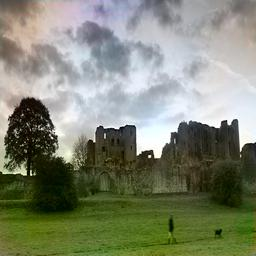

In [ ]:
imgres = "/content/results4/result100.jpg"
Image(imgres)

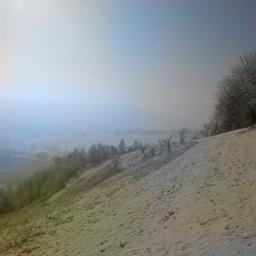

In [ ]:
imgres = "/content/results4/result150.jpg"
Image(imgres)

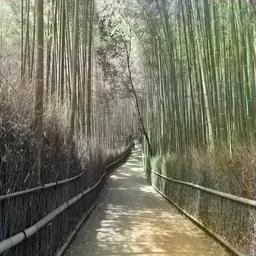

In [ ]:
imgres = "/content/results4/result200.jpg"
Image(imgres)

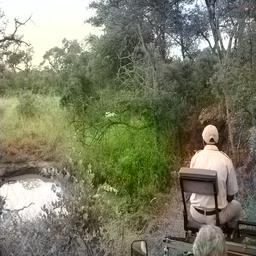

In [ ]:
imgres = "/content/results4/result249.jpg"
Image(imgres)

In [ ]:
accuracy = model.evaluate(np.array(test_input),  np.array(test_output), verbose=1)
print('test acc {:.3f}'.format(accuracy[1]))

test acc 0.813


To save the model as .h5, we need to run the next 3 cells.

In [ ]:
from keras.models import load_model
model.save("colorify.h5")
loaded_model = load_model("colorify.h5")

In [ ]:
from keras.models import load_model
model.save("decoder.h5")
newmodel.save("encoder.h5")

In [ ]:
import shutil
shutil.copy("/content/colorify.h5","/content/drive/MyDrive/Gate/temp/Major Project/Model/colorify.h5")

In [ ]:
shutil.move("/content/colorize.model","/content/drive/MyDrive/Gate/temp/Major Project/Model")

In [ ]:
################
!zip -r /content/original.zip /content/output/data/val/Humans

In [ ]:
from google.colab import files
files.download("/content/original.zip")

In [ ]:
from google.colab import files
files.download("/content/decoder.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>